In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

import numpy as np
import random
import os

class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_error = float('inf')
    
    def check(self, val_error, model):
        if val_error < self.min_error - self.min_delta:
            self.min_error = val_error
            torch.save(model.state_dict(), 'model_id_16.pth')
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def set_seed(seed=42):
    """
    Set random seeds for reproducibility across multiple libraries.
    
    Args
    ----
    seed (int): 
        Seed value to use
    """
    # Set PyTorch seed
    torch.manual_seed(seed)
    
    # Set CUDA seed (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
        
    
    # Set NumPy seed
    np.random.seed(seed)
    
    # Set Python's random seed
    random.seed(seed)
    
    # Set environment variable for some PyTorch operations
    os.environ['PYTHONHASHSEED'] = str(seed)

# Example usage
set_seed(42)  # or any other seed value

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()
        # BN-ReLU-Conv(1x1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        
        # BN-ReLU-Conv(3x3)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.drop_rate = drop_rate
        
    def forward(self, x):
        new_features = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(new_features)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.add_module('denselayer%d' % (i + 1),
                                  DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size, drop_rate))
            
    def forward(self, x):
        features = x
        for layer in self.layers:
            features = layer(features)
        return features

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 8), 
                 num_init_features=32, bn_size=4, drop_rate=0.3, num_classes=10):
        super(DenseNet, self).__init__()
        
        # First convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # Add a dense block
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            
            # Add a transition layer between dense blocks (except after the last block)
            if i != len(block_config) - 1:
                trans = Transition(in_channels=num_features, out_channels=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
        
        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# Create an instance of the model
model = DenseNet(growth_rate=12, block_config=(6, 12, 8), num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=0.0005)
# Alternative: optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Load and preprocess data (using your existing setup)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.ImageFolder('../../data/processed/train_augmented_cutout/', transform=transform)
valset = torchvision.datasets.ImageFolder('../../data/raw/valid/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

ES = EarlyStopper(patience=6, min_delta=0)

def train(epochs=5):
    time_started = time.time()
    _train_errors = []
    _val_errors = []
    
    for epoch in range(epochs):
        correct_train = 0
        total = 0
        running_loss = 0.0
        
        epoch_loss = 0.0
        total_batches = 0
        
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            correct_train += (torch.argmax(outputs, 1) == labels).float().sum().item()
            total += len(outputs)
            
            # Print statistics
            running_loss += loss.item()
            
            epoch_loss += loss.item()
            total_batches += 1
            
            if i % 200 == 199:    # Print every 200 mini-batches
                acc = correct_train / total
                print(f'[{epoch + 1}, {i + 1}], time {time.time() - time_started:.2f}s loss: {running_loss / 200:.3f}, acc: {acc * 100:.2f}%')
                running_loss = 0.0
                
        _train_errors.append(epoch_loss / total_batches)
        val_error = 0
        correct_val = 0
        
        model.eval()
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_error = val_error + criterion(outputs, labels) * images.size(0)
                correct_val += (torch.argmax(outputs, 1) == labels).float().sum().item()
            val_error = val_error / len(valloader.dataset)
            _val_errors.append(val_error)
            print(f'epoch {epoch + 1} TRAIN error: {epoch_loss / total_batches:.4f}, acc: {correct_train/total:.4f}')
            print(f'epoch {epoch + 1} VALIDATION error: {val_error:.4f}, acc: {correct_val/len(valloader.dataset):.4f}')

        if ES.check(val_error, model):
            print('Early stopping triggered!')
            return _train_errors, _val_errors
    
    return _train_errors, _val_errors

In [4]:
train_errors, val_errors = train(1000)

[1, 200], time 14.87s loss: 2.197, acc: 19.11%
[1, 400], time 25.52s loss: 2.033, acc: 22.08%
[1, 600], time 39.66s loss: 1.946, acc: 23.47%
[1, 800], time 56.80s loss: 1.866, acc: 24.92%
[1, 1000], time 74.06s loss: 1.818, acc: 26.16%
[1, 1200], time 91.35s loss: 1.781, acc: 27.36%
[1, 1400], time 108.44s loss: 1.748, acc: 28.28%
[1, 1600], time 125.61s loss: 1.727, acc: 29.17%
[1, 1800], time 142.82s loss: 1.709, acc: 29.88%
[1, 2000], time 159.45s loss: 1.674, acc: 30.62%
[1, 2200], time 176.30s loss: 1.677, acc: 31.25%
[1, 2400], time 193.16s loss: 1.627, acc: 31.87%
[1, 2600], time 210.54s loss: 1.624, acc: 32.45%
[1, 2800], time 227.33s loss: 1.618, acc: 32.97%
[1, 3000], time 244.52s loss: 1.599, acc: 33.44%
[1, 3200], time 262.16s loss: 1.585, acc: 33.89%
[1, 3400], time 280.05s loss: 1.541, acc: 34.42%
[1, 3600], time 298.23s loss: 1.550, acc: 34.90%
[1, 3800], time 315.65s loss: 1.519, acc: 35.37%
[1, 4000], time 333.29s loss: 1.510, acc: 35.77%
[1, 4200], time 351.32s loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026255097EC0>
Traceback (most recent call last):
  File "C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\popen_spawn_win32.py", line 109, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 

KeyboardInterrupt



In [4]:
val_errors = [error.item() for error in val_errors]
train_errors = [error.item() for error in train_errors]

AttributeError: 'float' object has no attribute 'item'

In [8]:
val_errors

[1.6108510494232178,
 1.303706169128418,
 1.3193238973617554,
 1.1337085962295532,
 1.0743013620376587,
 1.0907741785049438,
 0.9980283379554749,
 0.960150420665741,
 0.9742913246154785,
 0.9260371923446655,
 0.9130706787109375,
 0.8904606699943542,
 0.9035804867744446,
 0.8391384482383728,
 0.8235054612159729,
 0.8403693437576294,
 0.8634318709373474,
 0.8049992918968201,
 0.8217815160751343,
 0.7990504503250122,
 0.7943829298019409,
 0.7961642742156982,
 0.8075714707374573,
 0.7794702053070068,
 0.7807727456092834,
 0.7653247714042664,
 0.8106649518013,
 0.7753746509552002,
 0.8093498945236206,
 0.7374002933502197,
 0.7712966203689575,
 0.7622389793395996,
 0.7753984332084656,
 0.7551964521408081,
 0.7300814390182495,
 0.7306206822395325,
 0.7673443555831909,
 0.7328529357910156,
 0.7435054183006287,
 0.7836688160896301,
 0.7508396506309509]

In [7]:
train_errors

[1.6258006284713744,
 1.3391481558481853,
 1.2255304297235277,
 1.1490126905441285,
 1.092291749244266,
 1.0414373542573716,
 1.0016948072221543,
 0.9653898113568624,
 0.9328581651581658,
 0.9035453283839756,
 0.8763357019000583,
 0.8529457674715254,
 0.8332409968111251,
 0.8156133491198222,
 0.7993913671122657,
 0.7830263822078705,
 0.7682364916536543,
 0.7555496384037865,
 0.7443207234276665,
 0.7338161270353529,
 0.723503639766905,
 0.7154683708561791,
 0.7063647417174446,
 0.6984877710713281,
 0.6898717652691735,
 0.6834917883528604,
 0.6770793724086549,
 0.6710657076173359,
 0.6641697470982869,
 0.6610986264917585,
 0.6540546187162399,
 0.6513812861680984,
 0.6473874523242314,
 0.6437321736468209,
 0.6368697116004096,
 0.6387179642279943,
 0.6301615599473317,
 0.6262690821780099,
 0.6237188687298033,
 0.6202934967041016,
 0.615501912914382]

In [1]:
val_errors = [1.6108510494232178,
 1.303706169128418,
 1.3193238973617554,
 1.1337085962295532,
 1.0743013620376587,
 1.0907741785049438,
 0.9980283379554749,
 0.960150420665741,
 0.9742913246154785,
 0.9260371923446655,
 0.9130706787109375,
 0.8904606699943542,
 0.9035804867744446,
 0.8391384482383728,
 0.8235054612159729,
 0.8403693437576294,
 0.8634318709373474,
 0.8049992918968201,
 0.8217815160751343,
 0.7990504503250122,
 0.7943829298019409,
 0.7961642742156982,
 0.8075714707374573,
 0.7794702053070068,
 0.7807727456092834,
 0.7653247714042664,
 0.8106649518013,
 0.7753746509552002,
 0.8093498945236206,
 0.7374002933502197,
 0.7712966203689575,
 0.7622389793395996,
 0.7753984332084656,
 0.7551964521408081,
 0.7300814390182495,
 0.7306206822395325,
 0.7673443555831909,
 0.7328529357910156,
 0.7435054183006287,
 0.7836688160896301,
 0.7508396506309509]

In [2]:
train_errors = [1.6258006284713744,
 1.3391481558481853,
 1.2255304297235277,
 1.1490126905441285,
 1.092291749244266,
 1.0414373542573716,
 1.0016948072221543,
 0.9653898113568624,
 0.9328581651581658,
 0.9035453283839756,
 0.8763357019000583,
 0.8529457674715254,
 0.8332409968111251,
 0.8156133491198222,
 0.7993913671122657,
 0.7830263822078705,
 0.7682364916536543,
 0.7555496384037865,
 0.7443207234276665,
 0.7338161270353529,
 0.723503639766905,
 0.7154683708561791,
 0.7063647417174446,
 0.6984877710713281,
 0.6898717652691735,
 0.6834917883528604,
 0.6770793724086549,
 0.6710657076173359,
 0.6641697470982869,
 0.6610986264917585,
 0.6540546187162399,
 0.6513812861680984,
 0.6473874523242314,
 0.6437321736468209,
 0.6368697116004096,
 0.6387179642279943,
 0.6301615599473317,
 0.6262690821780099,
 0.6237188687298033,
 0.6202934967041016,
 0.615501912914382]

In [5]:
train_errors = [1.6258, 1.3391, 1.2255, 1.1490, 1.0923, 1.0414, 1.0017, 0.9654, 0.9329, 0.9035, 0.8763, 0.8529, 0.8332, 0.8156, 0.7994, 0.7830, 0.7682, 0.7555, 0.7443, 0.7338, 0.7235, 0.7155, 0.7064, 0.6985, 0.6899, 0.6835, 0.6771, 0.6711, 0.6642, 0.6611, 0.6541, 0.6514, 0.6474, 0.6437, 0.6369, 0.6387, 0.6302, 0.6263, 0.6237, 0.6203, 0.6155]

val_errors = [1.6109, 1.3037, 1.3193, 1.1337, 1.0743, 1.0908, 0.9980, 0.9602, 0.9743, 0.9260, 0.9131, 0.8905, 0.9036, 0.8391, 0.8235, 0.8404, 0.8634, 0.8050, 0.8218, 0.7991, 0.7944, 0.7962, 0.8076, 0.7795, 0.7808, 0.7653, 0.8107, 0.7754, 0.8093, 0.7374, 0.7713, 0.7622, 0.7754, 0.7552, 0.7301, 0.7306, 0.7673, 0.7329, 0.7435, 0.7837, 0.7508]

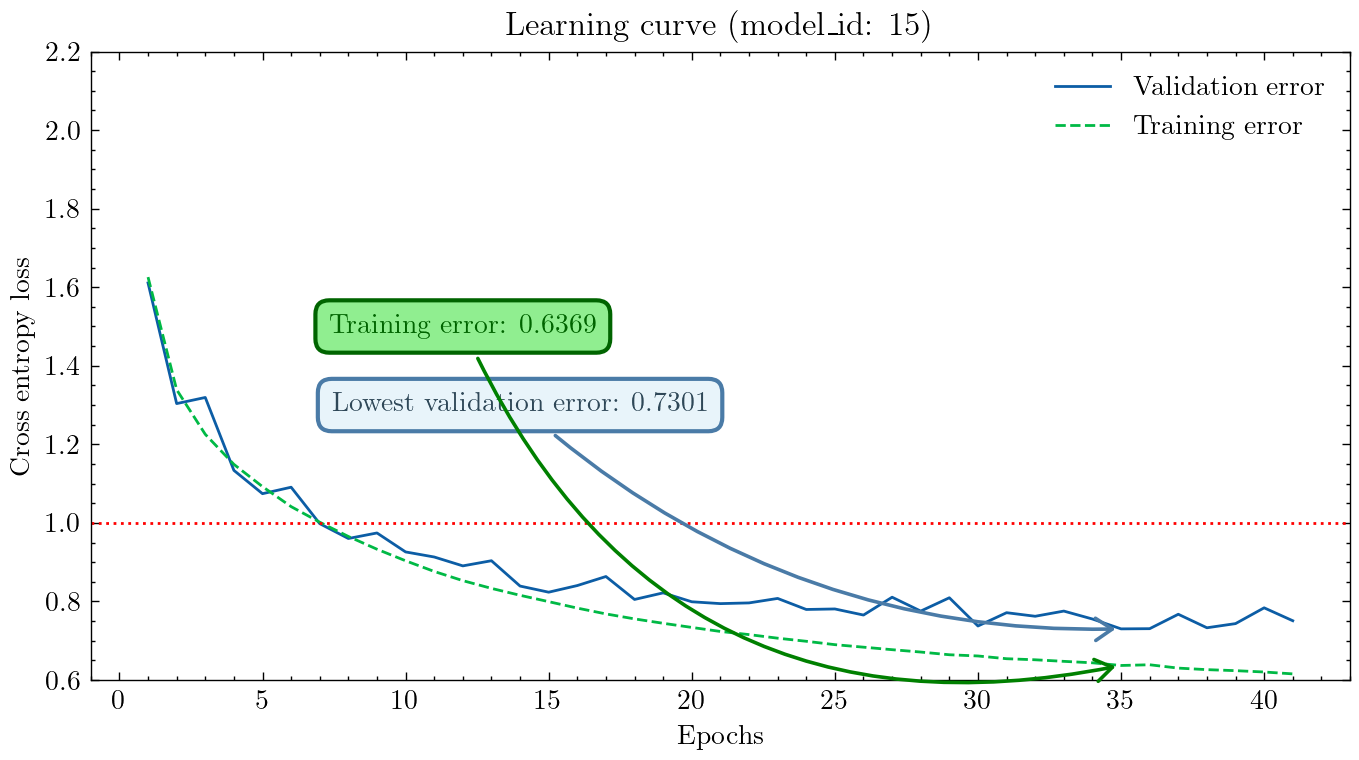

In [6]:
%matplotlib widget
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, dpi=200, figsize=(7, 4))
    
    x = [i + 1 for i in range(len(val_errors))]
    ax.plot(x, val_errors, label="Validation error")
    ax.plot(x, train_errors, linestyle="--", label="Training error")
    
    ax.set_title("Learning curve (model_id: 15)")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Cross entropy loss")
    ax.set_ylim([0.6, 2.2])
    ax.axhline(y = 1, color = 'r', linestyle = ':') 
    
    plt.legend()
    
    # Validation error annotation
    argmin_valerror = np.argmin(val_errors) + 1
    val_target_point = (argmin_valerror, val_errors[argmin_valerror-1])
    val_text_position = (14, 1.3)
    
    val_bbox_style = dict(
        boxstyle="round,pad=0.5",
        fc="#E8F4FA",        # Light blue background
        ec="#4A7BA7",        # Medium blue edge
        lw=1.5               # Slightly thicker edge
    )
    
    val_arrow_style = dict(
        arrowstyle="->,head_length=0.6,head_width=0.4",
        color="#4A7BA7",     # Match the box edge color
        connectionstyle="arc3,rad=.2",  # Slightly curved arrow
        lw=1.3               # Slightly thicker arrow
    )
    
    an1 = ax.annotate(
        f"Lowest validation error: {val_errors[argmin_valerror-1]:.4f}", 
        xy=val_target_point,       # Where the arrow points to
        xytext=val_text_position,  # Where the text box starts
        xycoords='data',
        textcoords='data',
        ha="center", va="center",
        fontsize=10,
        fontweight='medium',
        color="#2F4858",       # Dark blue text
        bbox=val_bbox_style,
        arrowprops=val_arrow_style
    )
    
    # Enable the draggable functionality
    an1.draggable()
    
    # Training error annotation
    argmin_trainerror = np.argmin(train_errors) + 1
    train_target_point = (argmin_valerror, train_errors[argmin_valerror-1])
    train_text_position = (12, 1.5)
    
    train_bbox_style = dict(
        boxstyle="round,pad=0.5",
        fc="lightgreen",        # Light orange background
        ec="darkgreen",        # Medium orange edge
        lw=1.5               # Slightly thicker edge
    )
    
    train_arrow_style = dict(
        arrowstyle="->,head_length=0.6,head_width=0.4",
        color="g",     # Match the box edge color
        connectionstyle="arc3,rad=.4",  # Slightly curved arrow in opposite direction
        lw=1.3               # Slightly thicker arrow
    )
    
    an2 = ax.annotate(
        f"Training error: {train_errors[argmin_valerror-1]:.4f}", 
        xy=train_target_point,       # Where the arrow points to
        xytext=train_text_position,  # Where the text box starts
        xycoords='data',
        textcoords='data',
        ha="center", va="center",
        fontsize=10,
        fontweight='medium',
        color="darkgreen",       # Dark orange text
        bbox=train_bbox_style,
        arrowprops=train_arrow_style
    )
    
    # Enable the draggable functionality
    an2.draggable()
    
    plt.tight_layout()
    plt.show()